In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from typing import Union
import pandas as pd
from joblib import Parallel, delayed

import seaborn as sns
import matplotlib.pyplot as plt

if 'src' in os.getcwd():
    os.chdir('..')

from create_data_examples import DatasetPreprocessor, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)


dataset = Dataset('german')

preprocessor = DatasetPreprocessor(dataset, one_hot=True, random_state=SEED)

X_train, X_test, y_train, y_test = preprocessor.get_numpy()

print(f'Shapes: X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}')

Shapes: X_train: (800, 61), X_test: (200, 61), y_train: (800,), y_test: (200,)


In [51]:
class MLPClassifier(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 output_dim: int, 
                 hidden_dims: list = [64, 64, 64],
                 activation: str = 'relu',
                 dropout: float = 0.0
        ) -> None:
        '''
        input_dim: int, input dimension
        output_dim: int, output dimension
        hidden_dims: list, hidden layer dimensions
        activation: str, activation function
        dropout: float, dropout rate
        '''
        super(MLPClassifier, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        self.activation = activation
        self.dropout = dropout
        self.layers = nn.ModuleList()
        self.build_model()

    def build_model(self):
        input_dim = self.input_dim
        for hidden_dim in self.hidden_dims:
            self.layers.append(nn.Linear(input_dim, hidden_dim))
            if self.activation == 'relu':
                self.layers.append(nn.ReLU())
            elif self.activation == 'tanh':
                self.layers.append(nn.Tanh())
            elif self.activation == 'sigmoid':
                self.layers.append(nn.Sigmoid())
            else:
                raise ValueError('Invalid activation function')
            if self.dropout > 0:
                self.layers.append(nn.Dropout(self.dropout))
            input_dim = hidden_dim
        self.layers.append(nn.Linear(input_dim, self.output_dim))
        self.layers.append(nn.Softmax(dim=1))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def predict_proba(self, x):
        return self.forward(x)
    
    def predict_crisp(self, x):
        return torch.argmax(self.predict_proba(x), dim=1)
    
    def fit(self, 
            X_train: Union[np.array, torch.Tensor],
            y_train: Union[np.array, torch.Tensor],
            X_val: Union[np.array, torch.Tensor] = None,
            y_val: Union[np.array, torch.Tensor] = None,
            epochs: int = 100,
            lr: float = 0.002, 
            batch_size: int = 256,
            verbose: bool = True,
            early_stopping: bool = True,
            device: str = 'cpu'
        ) -> None:
        '''
        '''
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        X_train = array_to_tensor(X_train, device=device, dtype=torch.float32)
        y_train = array_to_tensor(y_train, device=device, dtype=torch.long)
        if X_val is not None:
            X_val = array_to_tensor(X_val, device=device, dtype=torch.float32)
            y_val = array_to_tensor(y_val, device=device, dtype=torch.long)
            
            
        for epoch in range(epochs):
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                optimizer.zero_grad()
                y_pred = self.forward(X_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                
            
            
            if verbose:
                if epoch % 10 == 0:
                    print(f'Epoch: {epoch}, Loss: {loss.item()}')
            
            if early_stopping:
                if X_val is not None:
                    self.eval()
                    y_pred_val = self.forward(X_val)
                    val_loss = criterion(y_pred_val, y_val)
                    if verbose:
                        if epoch % 10 == 0:
                            print(f'Epoch: {epoch}, Validation Loss: {val_loss.item()}')
                    if val_loss < 0.01:
                        break
                else:
                    if loss < 0.01:
                        break
                    
    def evaluate(self, 
                 X_test: Union[np.array, torch.Tensor],
                 y_test: Union[np.array, torch.Tensor],
                 device: str = 'cpu'
        ) -> float:
        '''
        X_test: np.array | torch.Tensor, test data
        y_test: np.array | torch.Tensor, test labels
        device: str, device to use
        '''
        self.eval()
        X_test = array_to_tensor(X_test, device=device)
        y_test = array_to_tensor(y_test, device=device)
        y_pred = self.predict_crisp(X_test)
        accuracy = (y_pred == y_test).sum().item() / len(y_test)
        recall = recall_score(y_test, y_pred, average='binary')
        precision = precision_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        
        return accuracy, recall, precision, f1
    
        
    

                    
def array_to_tensor(X: Union[np.array, torch.Tensor], 
                    device: str = 'cpu',
                    dtype: torch.dtype = torch.float32
    ) -> torch.Tensor:
    '''
    X: np.array, array to convert, or torch.Tensor
    device: str, device to use
    dtype: torch.dtype, data type
    '''
    if isinstance(X, np.ndarray):
        X = torch.tensor(X, dtype=dtype)
        
    return X.to(device)
    
        
        

In [52]:
mlp = MLPClassifier(input_dim=X_train.shape[1], output_dim=2, hidden_dims=[16, 16, 16], activation='relu', dropout=0.1)

mlp.fit(
    X_train, 
    y_train, 
    X_val=X_test, 
    y_val=y_test
)

accuracy, recall, precision, f1 = mlp.evaluate(X_test, y_test)

print(f'Accuracy: {accuracy}, Recall: {recall}, Precision: {precision}, F1: {f1}')

Epoch: 0, Loss: 0.6799245476722717
Epoch: 0, Validation Loss: 0.6764631867408752
Epoch: 10, Loss: 0.6169472336769104
Epoch: 10, Validation Loss: 0.6023653149604797
Epoch: 20, Loss: 0.5057129263877869
Epoch: 20, Validation Loss: 0.5671982169151306
Epoch: 30, Loss: 0.436215877532959
Epoch: 30, Validation Loss: 0.5592845678329468
Epoch: 40, Loss: 0.4157538414001465
Epoch: 40, Validation Loss: 0.5574848055839539
Epoch: 50, Loss: 0.41122838854789734
Epoch: 50, Validation Loss: 0.567503809928894
Epoch: 60, Loss: 0.40907761454582214
Epoch: 60, Validation Loss: 0.5761190056800842
Epoch: 70, Loss: 0.4077084958553314
Epoch: 70, Validation Loss: 0.5722090005874634
Epoch: 80, Loss: 0.40736350417137146
Epoch: 80, Validation Loss: 0.5715053081512451
Epoch: 90, Loss: 0.407222718000412
Epoch: 90, Validation Loss: 0.5709624290466309
Accuracy: 0.745, Recall: 0.8714285714285714, Precision: 0.7870967741935484, F1: 0.8271186440677966


In [53]:
def train_K_mlps(X_train, y_train, X_test, y_test, K: int = 5, evaluate: bool = True):
    '''
    X_train: np.array, training data
    y_train: np.array, training labels
    X_test: np.array, test data
    y_test: np.array, test labels
    K: int, number of models to train
    '''
    accuracies = []
    recalls = []
    precisions = []
    f1s = []
    models = []
    for k in range(K):
        layers = np.random.randint(2, 5)
        dims = np.random.choice([16,24,32], size=layers)
        dropout = np.random.randint(0,3) / 10
        mlp = MLPClassifier(input_dim=X_train.shape[1], output_dim=2, hidden_dims=dims, activation='relu', dropout=dropout)
        mlp.fit(
            X_train, 
            y_train, 
            X_val=X_test, 
            y_val=y_test,
            verbose=False,
            early_stopping=False,
            lr=0.01,
            epochs=20
        )
        accuracy, recall, precision, f1 = mlp.evaluate(X_test, y_test)
        accuracies.append(accuracy)
        recalls.append(recall)
        precisions.append(precision)
        f1s.append(f1)
        models.append(mlp)
    return models, accuracies, recalls, precisions, f1s


def train_K_mlps_in_parallel(X_train, y_train, X_test, y_test, K: int = 20, n_jobs: int = 4):
    '''
    X_train: np.array, training data
    y_train: np.array, training labels
    X_test: np.array, test data
    y_test: np.array, test labels
    K: int, number of models to train
    n_jobs: int, number of jobs to run in parallel
    '''
    
    k_for_each_job = K // n_jobs 
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(train_K_mlps)(X_train, y_train, X_test, y_test, k_for_each_job) for _ in range(n_jobs)
    )
    return results

results = train_K_mlps_in_parallel(X_train, y_train, X_test, y_test, K=24, n_jobs=4)

accuracies = [accuracy for _, accuracy, _, _, _ in results]
accuracies = np.array(accuracies).flatten()
print(f'Accuracies: {accuracies}')
models = [model for model, _, _, _, _ in results]
models = [model for sublist in models for model in sublist]
print(f'Number of models: {len(models)}')

Accuracies: [0.69  0.69  0.73  0.75  0.72  0.735 0.67  0.74  0.74  0.73  0.695 0.73
 0.7   0.69  0.735 0.75  0.725 0.73  0.72  0.715 0.75  0.74  0.74  0.74 ]
Number of models: 24


In [54]:
def ensemble_predict_proba(models: list[nn.Module], X: Union[np.ndarray, torch.Tensor]) -> list[float]:
    '''
    models: list, list of trained models
    X: np.array, data
    '''
    predictions = []
    X_tensor = array_to_tensor(X)
    for model in models:
        predictions.append(model.predict_proba(X_tensor).detach().numpy()[:, 1])
    predictions = np.array(predictions)
    return predictions

preds = ensemble_predict_proba(models, X_test)
print(preds.shape)
print(f'Ensemble Predictions: {preds[:, 7]}')

(24, 200)
Ensemble Predictions: [0.50494504 0.40653518 0.43972516 0.33733124 0.1857272  0.6737239
 0.3318001  0.07545323 0.2618563  0.08787909 0.15254758 0.33585528
 0.4935687  0.16944845 0.6177424  0.03048743 0.04687036 0.33452702
 0.99959916 0.27032208 0.34727877 0.03730207 0.247442   0.07735928]


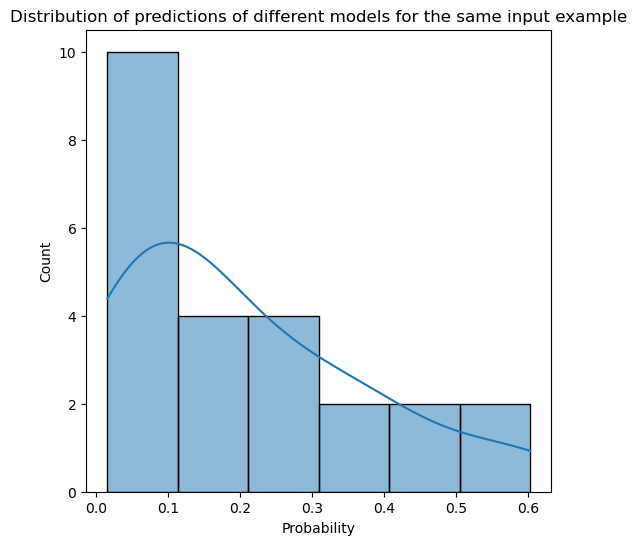

[0.60215765 0.40653518 0.55382353 0.42674878 0.01959497 0.05847571
 0.30436072 0.03899316 0.21221596 0.07796966 0.12416793 0.21715276
 0.17021489 0.1768381  0.25043014 0.01519928 0.02296397 0.33080915
 0.11169028 0.13365363 0.34727877 0.10652615 0.07248651 0.04340673]


In [55]:
def plot_distribution_of_predictions(predictions: Union[list[float], np.ndarray], save_dir: Union[str, None] = None) -> None:
    
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    if isinstance(predictions, list):
        preds = np.ndarray(predictions, dtype=np.float64)
    else:
        preds = predictions
        
    fig = plt.figure(figsize=(6,6))
    # plt.hist(preds, bins=50, density=True)
    sns.histplot(preds, kde=True)
    
    if save_dir:
        path = os.path.join(save_dir, 'distribution_of_predictions.png')
        plt.savefig(path, dpi=300)
        
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.title('Distribution of predictions of different models for the same input example')
    
    plt.show()
    

example_preds = preds[:, 8]
plot_distribution_of_predictions(example_preds, save_dir='images/statrob')
    
print(example_preds)
    

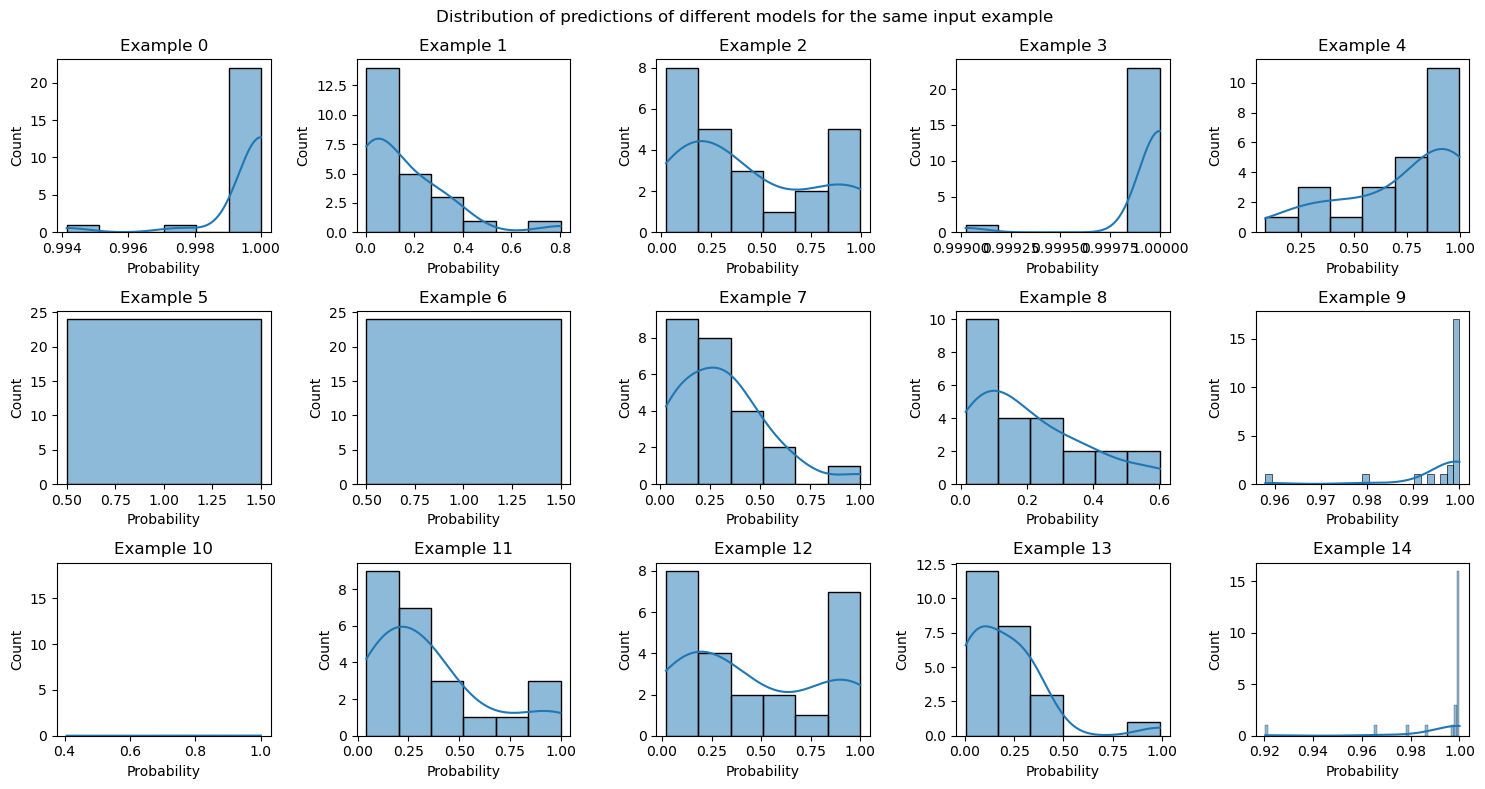

In [68]:
def plot_grid_of_distribution_predictions(predictions: Union[list[list[float]], np.ndarray], 
                                          save_dir: Union[str, None] = None,
                                          rows: int = 3,
                                          cols: int = 5
    ) -> None:
    
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    if isinstance(predictions, list):
        preds = np.ndarray(predictions, dtype=np.float16)
    else:
        preds = predictions.astype(np.float16)
        
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(rows * cols):
        
        sns.histplot(preds[:, i], kde=True, ax=axes[i])
        
        # last row
        # if i // cols == rows - 1: 
        axes[i].set_xlabel('Probability')
            
        # if i % cols == 0:
        axes[i].set_ylabel('Count')
        
        axes[i].set_title(f'Example {i}')
        
    plt.suptitle('Distribution of predictions of different models for the same input example')
    plt.tight_layout()
    
    if save_dir:
        path = os.path.join(save_dir, 'grid_of_predictions_distributions.png')
        plt.savefig(path, dpi=300)
        
    plt.show()
    
    
plot_grid_of_distribution_predictions(preds, save_dir='images/statrob')

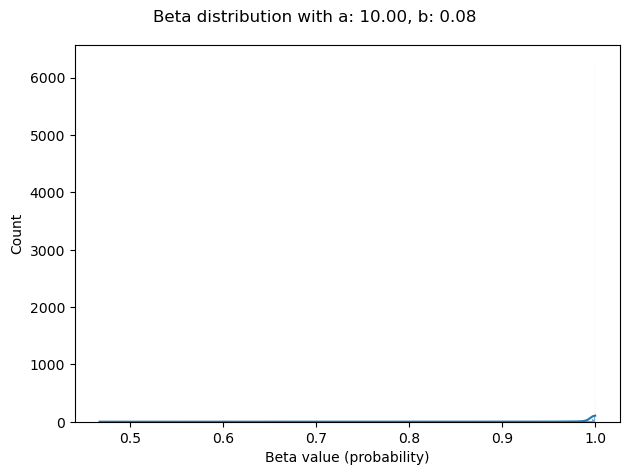

In [88]:
def __estimate_beta_params_moments(sample: np.ndarray) -> tuple[float, float]:
    
    s_mean = np.mean(sample)
    s_var = np.var(sample)
    
    assert s_var < s_mean * (1 - s_mean), f'Method of moments can be used only if [s_var < s_mean * (1 - s_mean)] is satisfied'
    
    tmp = s_mean * (1 - s_mean) / s_var - 1
    alpha = s_mean * tmp
    beta = (1 - s_mean) * tmp
    
    return alpha, beta

def estimate_beta_distribution(
    sample: np.ndarray,
    method: str = 'moments',
    ) -> tuple[float, float]:
    '''
    Estimate beta distribution based on a sample
    
    Parameters:
        - sample (np.ndarray): a 1D array of size N
        - method (str): either 'moments' or 'MLE'. This decides the method of parameter estimation.
        
    Returns:
        - (alpha, beta) parameters of the estimated beta distribution 
    ''' 
    
    match method:
        case 'moments': 
            alpha, beta = __estimate_beta_params_moments(sample)
        case 'MLE':
            raise NotImplementedError('MLE estimation is not implemented yet!')
        case _:
            raise ValueError(f'Estimation method not known: {method} should be either "moments" or "MLE"!')
        
    return alpha, beta

def plot_beta(
    alpha: float,
    beta: float,
    sample_size: int = 10000,
    save_dir: Union[str, None] = None,
    ) -> None:
    
    samples = np.random.beta(alpha, beta, size=sample_size)
    
    
    sns.histplot(samples, kde=True)
    
    plt.suptitle(f'Beta distribution with a: {alpha:.2f}, b: {beta:.2f}')
    plt.xlabel('Beta value (probability)')
    plt.ylabel('Count')
    plt.tight_layout()
    
    plt.show()

        

s = preds[:, 0]
alpha, beta = estimate_beta_distribution(s, method='moments')

alpha = np.clip(alpha, 0, 10)
beta = np.clip(beta, 0, 10)

plot_beta(alpha, beta)
            
    
    
    